By Drilon & Chia-Hua

# CNN - CIFAR10 - Data Augmentation

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

170498071/170498071 [==============================] - 4s 0us/step


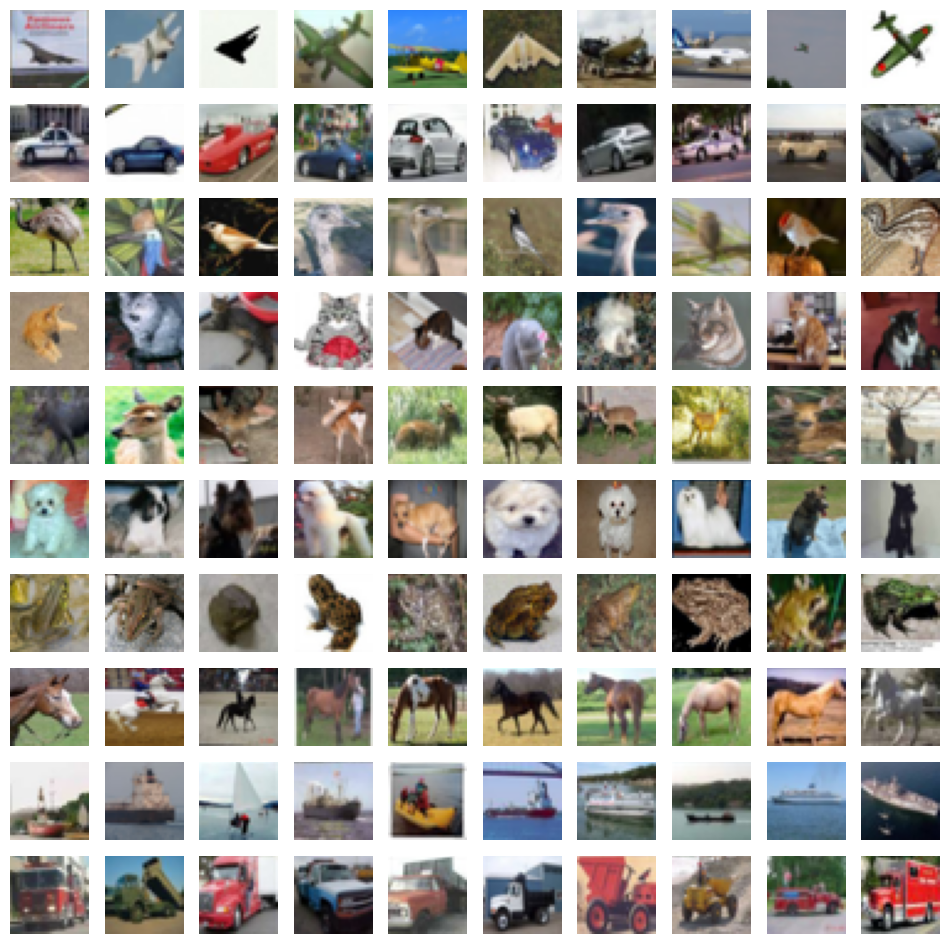

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [3]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in :

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`

Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [5]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [6]:
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:]))
cnn.add(Activation('relu'))

cnn.add(Conv2D(32, kernel_size=(3,3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, kernel_size=(3,3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())
cnn.add(Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                        

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [7]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
391/391 [==============================] - 8s 11ms/step - loss: 1.6027 - accuracy: 0.4257 - val_loss: 1.2977 - val_accuracy: 0.5417
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2181 - accuracy: 0.5722 - val_loss: 1.1101 - val_accuracy: 0.6133
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 1.0518 - accuracy: 0.6337 - val_loss: 1.0194 - val_accuracy: 0.6489
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 0.9599 - accuracy: 0.6675 - val_loss: 0.9977 - val_accuracy: 0.6599
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8951 - accuracy: 0.6927 - val_loss: 0.9497 - val_accuracy: 0.6727
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8517 - accuracy: 0.7076 - val_loss: 0.9008 - val_accuracy: 0.6952
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8139 - accuracy: 0.7189 - val_loss: 0.8893 - val_accuracy: 0.6944
Epoch

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

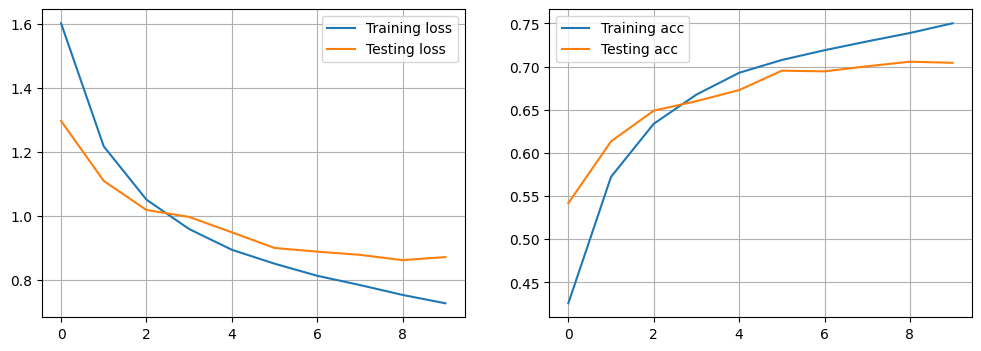

In [8]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [9]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8723941445350647
Test accuracy: 0.7042999863624573


### Confusion matrix
We can call the `predict()` function to get the predicted classes. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [10]:
pred = cnn.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

array([[819,   8,  25,  10,  13,   8,   8,   6,  71,  32],
       [ 47, 769,   4,   4,   3,   4,   7,   1,  40, 121],
       [104,   3, 451,  48, 163,  81,  78,  33,  20,  19],
       [ 51,  12,  57, 457,  96, 185,  66,  28,  28,  20],
       [ 30,   3,  37,  42, 739,  39,  46,  39,  14,  11],
       [ 25,   1,  41, 126,  80, 644,  22,  35,  15,  11],
       [ 12,   5,  29,  46,  66,  24, 790,   5,  12,  11],
       [ 35,   5,  32,  31,  83,  65,   8, 713,   5,  23],
       [ 87,  24,   6,   9,   7,   4,   6,   5, 828,  24],
       [ 57,  43,   5,   8,   8,   6,   5,  10,  25, 833]])

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by heart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.3, zoom_range=0.1, horizontal_flip=True)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above.

In [12]:
cnn_aug = Sequential()

cnn_aug.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:]))
cnn_aug.add(Activation('relu'))

cnn_aug.add(Conv2D(32, kernel_size=(3,3), padding='same'))
cnn_aug.add(Activation('relu'))
cnn_aug.add(MaxPooling2D(pool_size=(2,2)))

cnn_aug.add(Conv2D(32, kernel_size=(3,3), padding='same'))
cnn_aug.add(Activation('relu'))
cnn_aug.add(MaxPooling2D(pool_size=(2,2)))

cnn_aug.add(Flatten())
cnn_aug.add(Dense(10, activation='softmax'))

cnn_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                      

In [ ]:
cnn_aug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_aug.fit(generator.flow(X_train, Y_train, batch_size=128), validation_data=generator.flow(X_test,Y_test, batch_size=128), epochs=10, verbose=1)

Epoch 1/10
391/391 [==============================] - 34s 84ms/step - loss: 1.8214 - accuracy: 0.3440 - val_loss: 1.6609 - val_accuracy: 0.4035
Epoch 2/10
391/391 [==============================] - 32s 81ms/step - loss: 1.6462 - accuracy: 0.4121 - val_loss: 1.5778 - val_accuracy: 0.4334
Epoch 3/10
391/391 [==============================] - 32s 82ms/step - loss: 1.5449 - accuracy: 0.4501 - val_loss: 1.4908 - val_accuracy: 0.4690
Epoch 4/10
391/391 [==============================] - 31s 79ms/step - loss: 1.4752 - accuracy: 0.4773 - val_loss: 1.4437 - val_accuracy: 0.4931
Epoch 5/10
391/391 [==============================] - 32s 82ms/step - loss: 1.4158 - accuracy: 0.5009 - val_loss: 1.3825 - val_accuracy: 0.5118
Epoch 6/10
391/391 [==============================] - 37s 95ms/step - loss: 1.3770 - accuracy: 0.5100 - val_loss: 1.3704 - val_accuracy: 0.5140
Epoch 7/10
391/391 [==============================] - 39s 100ms/step - loss: 1.3437 - accuracy: 0.5242 - val_loss: 1.3014 - val_accuracy

## Adjusting Transformation
We think that the transformations are too aggressive, so that the performance decreased instead of increasing. that's why we created a new generator and tried it again below.

In [30]:
def create_train_report(gen):
    cnn = Sequential()

    cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:]))
    cnn.add(Activation('relu'))

    cnn.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Flatten())
    cnn.add(Dense(10, activation='softmax'))

    cnn.summary()

    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    results = cnn.fit(gen.flow(X_train, Y_train, batch_size=128), validation_data=gen.flow(X_test,Y_test, batch_size=128), epochs=20, verbose=1)

    loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)

    print('Test loss:', loss_test)
    print('Test accuracy:', metric_test)

    return results, cnn

In [15]:
generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.15, zoom_range=0.05, horizontal_flip=True)
log, mod = create_train_report(generator)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        9248      
                                                      

In [16]:
def plot_performance(log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Testing loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Testing acc')
    ax2.legend()
    ax2.grid()

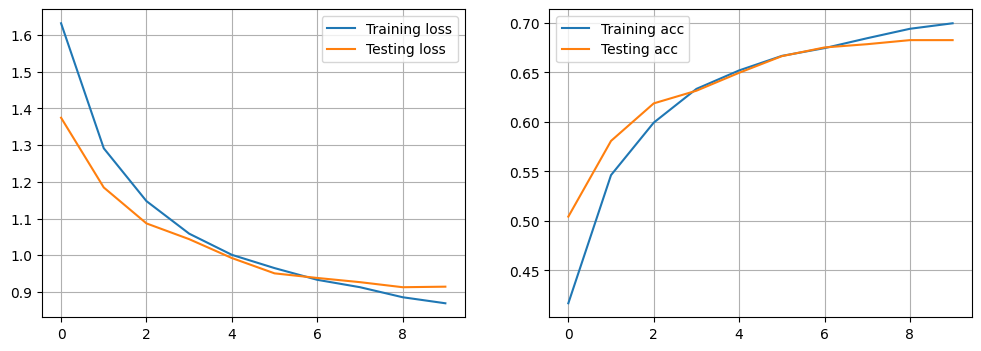

In [17]:
plot_performance(log)

In [31]:
generator = ImageDataGenerator(rotation_range=5, width_shift_range=0.025, height_shift_range=0.025, shear_range=0.07, zoom_range=0.01, horizontal_flip=False)
log, mod = create_train_report(generator)
plot_performance(log)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_15 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_16 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        9248      
                                                      

KeyboardInterrupt: 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_18 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_19 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 32)        9248      
                                                      

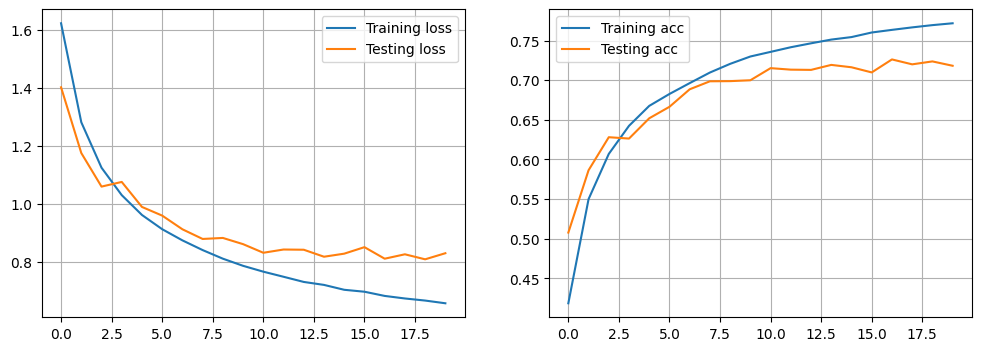

In [32]:
generator = ImageDataGenerator(rotation_range=5, width_shift_range=0.025, height_shift_range=0.025, shear_range=0.07, zoom_range=0.01, horizontal_flip=False)
log, mod = create_train_report(generator)
plot_performance(log)

### Table of results

Describe your data augmentation strategies here.

| CNN        | Architecture description | Acc. train | Acc. test |
|------------|--------------------------|------------|-----------|
| No DA, 10 ep      | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 75%        | 70%       |
| With DA v1, 10 ep | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | <60%       | <60%      |
| With DA v2, 10 ep | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 70%       | 70%       |
| With DA v3, 10 ep | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 73%        | 70%       |
| With DA v3, 20 ep | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 78%        | 73%       |

## Findings
We can see that training for 10 epochs with data augmentation indicates a improved model generalization, even tough there is no increase in overall accuracy. The reduced discrepancy between training and test accuracies suggests the model is learning more universal features rather than memorizing the training data, just as seen in the lecture. This outcome highlights data augmentation's potential in enhancing model robustness and sets a foundation for further performance improvements. To test this, we did a final run with 20 epochs to see if it is possible to increase accuracy and still maintain a model which generalizes well, as can be seen in the final entry of the table.

## Visualizing What My Model Learns

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.
Here we attempt to visualize the intermediate CNN outputs (intermediate activations). Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network.
We want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

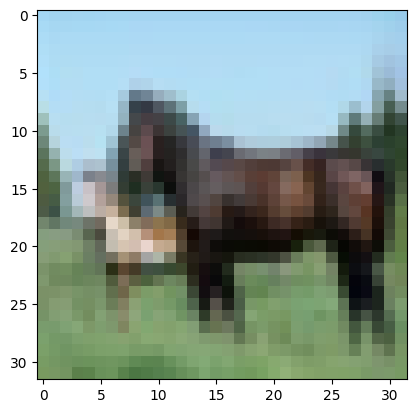

In [19]:
# visualize image number 12
test_im1 = X_train[12]
plt.imshow(test_im1)
plt.show()

1/1 [==============================] - 0s 75ms/step


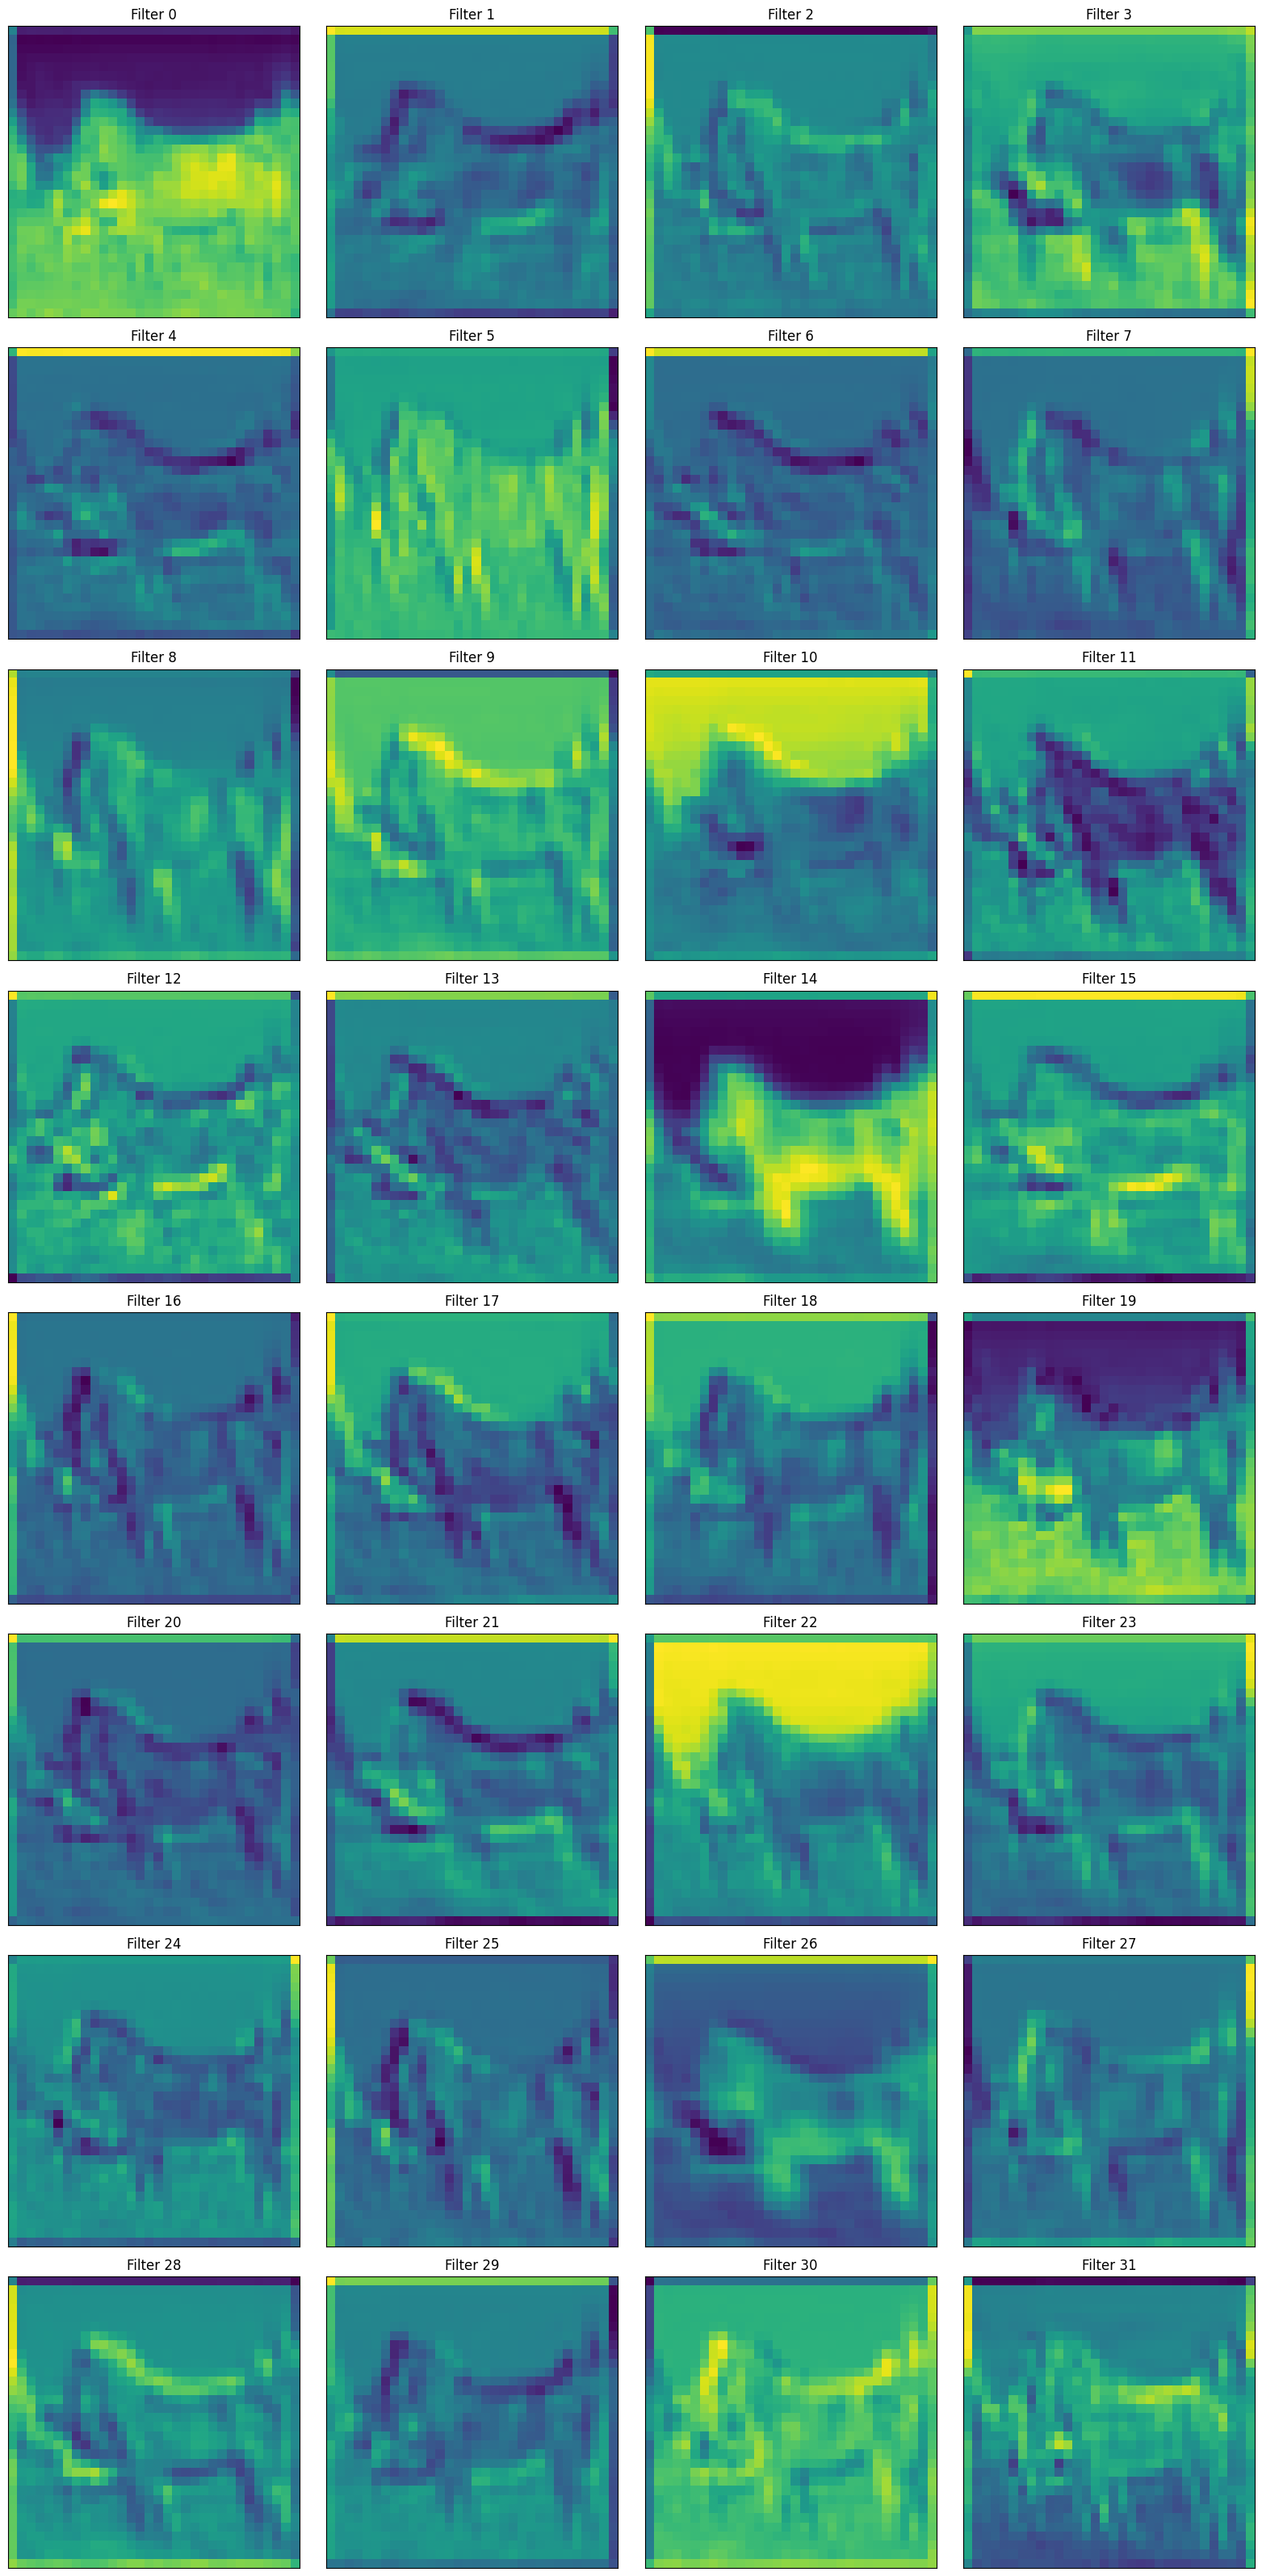

In [26]:
#  Now implement a code to visualise all the filters at a given layer.
#  Hints : use subplots to have a grid of images, use for loops to avoid code repetition.
layer_1st_conv = mod.layers[0].output

activation_model = tf.keras.models.Model(inputs=mod.input, outputs=layer_1st_conv)

test_im1 = test_im1.reshape(1,32, 32, 3)
first_layer_activation = activation_model.predict(test_im1)

num_filters = first_layer_activation.shape[-1]

rows = num_filters // 4 + int(num_filters % 4 > 0)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        filter_index = i * cols + j
        if filter_index < num_filters:
            ax.matshow(first_layer_activation[0, :, :, filter_index], cmap='viridis')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Filter {filter_index}')
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()
#  Use the code shown in-class to perform this exercise

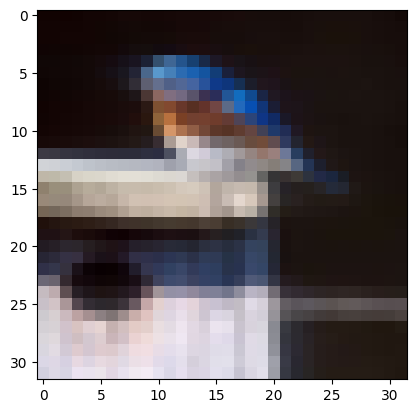

1/1 [==============================] - 0s 63ms/step


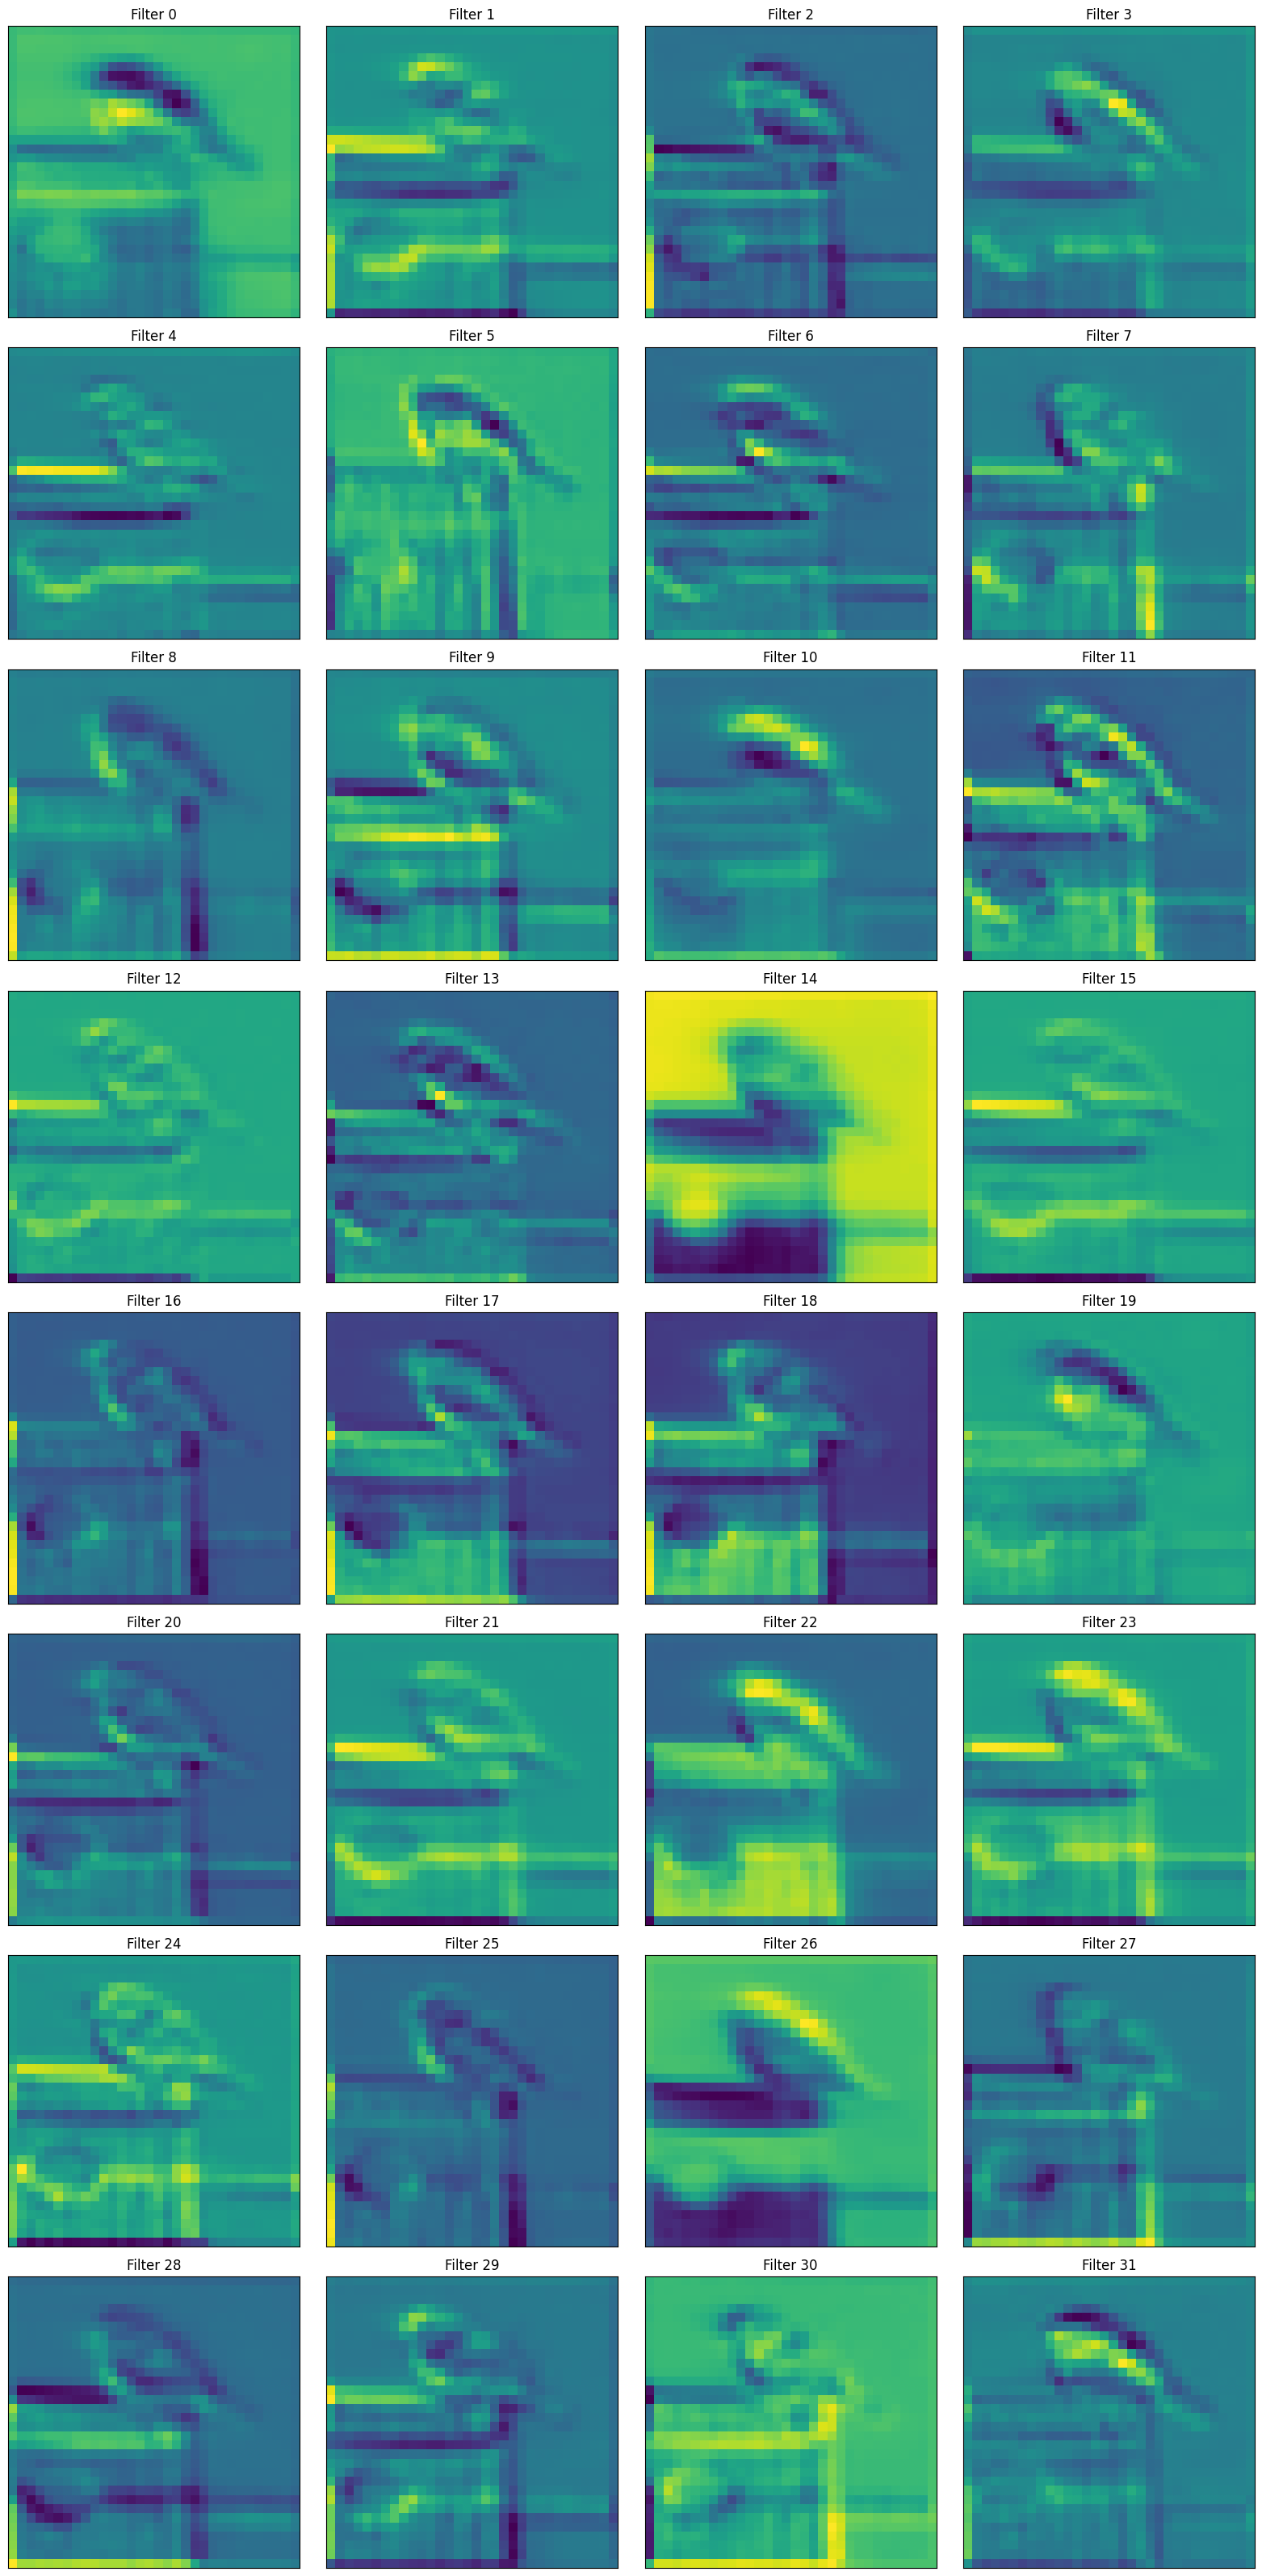

In [28]:
test_im1 = X_train[13]
plt.imshow(test_im1)
plt.show()

layer_1st_conv = mod.layers[0].output

activation_model = tf.keras.models.Model(inputs=mod.input, outputs=layer_1st_conv)

test_im1 = test_im1.reshape(1,32, 32, 3)
first_layer_activation = activation_model.predict(test_im1)

num_filters = first_layer_activation.shape[-1]

rows = num_filters // 4 + int(num_filters % 4 > 0)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        filter_index = i * cols + j
        if filter_index < num_filters:
            ax.matshow(first_layer_activation[0, :, :, filter_index], cmap='viridis')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Filter {filter_index}')
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()

## Optional : Deeper Models
Let's play here with a deeper CNN model on CIFAR10 using a structure inspired by VGGNet: [[Conv2D $\rightarrow$ relu $\rightarrow$ BN]*3 $\rightarrow$ MaxPool2D $\rightarrow$ Dropout]*4 $\rightarrow$ Flatten $\rightarrow$ Dense $\rightarrow$ Dropout $\rightarrow$ Out.
In this structure, BN means Batch Normalisation. You can try different options but a configuration with blocks of 64 filters of size 3 with same padding and stride 1, max pooling of size 2 and stride 2, dropouts of 0.2 and a dense layer of 256 neurons should bring your performance around 80-85\% on CIFAR10.

You probably  need to use a GPU to train such networks and play with different settings. You may use freely available GPUs on Colab, see https://colab.research.google.com/
To activate the gpu on Colab, go to Edit > Notebook settings and select GPU.}. Report your best performances with and without data augmentation as in Exercise 1. What are your observations.

In [ ]:
#  Your code here

## Analysis of a Deep Architecture

The analysis of the deep CNN architectures we did in the class covered the evolution observed on the ImageNet LSVRC competition until 2017. New architectures were introduced after that, such as for exemple the **Inception-v4**, **XCeption**, **EfficientNet**, etc. Other strategies based on deep CNNs have also emerged for other tasks such as *image detection* (finding bounding boxes around the objects of interest), such as **Yolo** (v1 to v6).

- Pick one of these new architectures that you find interesting (Inception-v4, XCeption, EfficientNet, Yolo, or another one).
- List and provide the reference(s) explaining the architecture (at least the reference to the original paper(s) presenting the architecture).
- Read the article(s) up to the point you have a general understanding of their strategy - no need to understand all the details!
- Re-explain in few phrases what you understood from the architecture doing comparison with the architectures presented in the class.

YOUR REPORT ABOUT A CHOSEN ARCHITECTURE HERE

#### Inception-v4

- [Inception v1](https://arxiv.org/pdf/1409.4842v1.pdf)
- [Inception v2 and Inception v3](https://arxiv.org/pdf/1512.00567v3.pdf) were presented in the same paper.
- [Inception v4 and Inception-ResNet](https://arxiv.org/pdf/1602.07261.pdf) were presented in the same paper.

The Inception network is used in image recognition and processing. It's designed to efficiently process images at different scales and sizes, capturing details both globally and locally.

- Inception-v4 is an advanced evolution of GoogLeNet, which is also known as Inception-v1. 
- Inception-v4 introduces more uniform and streamlined Inception modules, enhancing the model's efficiency and accuracy.
- While GoogLeNet focused on depth and innovative inception modules, Inception-v4 further optimizes these concepts, providing clearer structures and incorporating lessons learned from previous versions to improve performance in image recognition tasks.


## Optional: Review Questions

See pdf of this Practical Work for the review questions.